In [1]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from rl.agent import *
from rl.utils import *
import gym
from gym import wrappers
import math

GAMMA = 0.95

In [2]:
def build_model(state_size):
    model = Sequential()

    model.add(Linear(state_size, 10))
    model.add(Tanh())

    model.add(Linear(10, 2))
    model.add(SoftMax())
    return model


def create_agent(x):
    env = gym.make('CartPole-v1')
    return REINFORCEAgent(env, 498)


def calc_baseline(r_rewards):
    max_steps = r_rewards.map(lambda x: x.shape[0]).max()
    pad = r_rewards.map(lambda x: np.pad(x, (0, max_steps-x.shape[0]), 'constant'))
    sum, count = pad.map(lambda x: (x, 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    mean = sum / count
    return mean


def normalize(records, eps=1e-8):
    stats = records.map(lambda x: x[2]).stats()

    mean = stats.mean()
    std = stats.sampleStdev()

    return records.map(lambda x: (x[0], x[1], (x[2] - mean) / (std + eps)))

In [3]:
init_engine()
init_executor_gateway(sc)
redire_spark_logs()

In [4]:
node_num, core_num = get_node_and_core_number()
parallelism = node_num * core_num

In [6]:
# test environment on driver
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, "/tmp/cartpole-experiment", video_callable=lambda x: True, force=True)
test_agent = REINFORCEAgent(env, 1000)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = build_model(state_size)
criterion = PGCriterion()

# create and cache several agents on each partition as specified by parallelism
# and cache it
with DistributedAgents(sc, create_agent=create_agent, parallelism=parallelism) as a:
    # a.agents is a RDD[Agent]
    agents = a.agents
    optimizer = None
    num_trajs_per_part = int(math.ceil(15.0 / parallelism))
    mean_std = []

    for i in range(60):
        with SampledTrajs(sc, agents, model, num_trajs_per_part=num_trajs_per_part) as trajs:
            # samples is a RDD[Trajectory]
            trajs = trajs.samples \
                .map(lambda traj: (traj.data["observations"],
                                   traj.data["actions"],
                                   traj.data["rewards"]))

            rewards_stat = trajs.map(lambda traj: traj[2].sum()).stats()
            
            reward_mean = rewards_stat.mean()
            reward_std = rewards_stat.sampleStdev()
            reward_max = rewards_stat.max()
            mean_std.append([reward_mean, reward_std])

            print "*********** steps %s **************" % i
            print "reward mean:", reward_mean
            print "reward std:", reward_std
            print "reward max:", reward_max

            # calculate the discounted sum of future rewards
            trajs = trajs.map(lambda x: (x[0], x[1], discounted_sum_of_future_rewards(x[2], GAMMA)))

            # calculate advantages
            baseline = calc_baseline(trajs.map(lambda x: x[2]))
            trajs = trajs.map(lambda x: (x[0], x[1], x[2] - baseline[:len(x[2])]))

            # trajectories to records
            records = trajs.flatMap(lambda x: [(x[0][i], x[1][i], x[2][i]) for i in range(len(x[0]))])

            num_records = records.count()
            batch_size = num_records - num_records % parallelism

            print "total %s num_records" % num_records
            print "using %s batch_size" % batch_size

            # normalize advantages
            normalized = normalize(records)

            # to bigdl sample
            data = normalized.map(obs_act_adv_to_sample)

            # update one step
            if optimizer is None:
                optimizer = Optimizer(model=model,
                                      training_rdd=data,
                                      criterion=criterion,
                                      optim_method=RMSprop(learningrate=0.005),
                                      end_trigger=MaxIteration(1),
                                      batch_size=batch_size)
            else:
                optimizer.set_traindata(data, batch_size)
                optimizer.set_end_when(MaxIteration(i + 1))

            model = optimizer.optimize()

            if (i + 1) % 10 == 0:
                import time

                start = time.time()
                step = test_agent.sample(model, num_trajs=1)[0].data["actions"].shape[0]
                end = time.time()
                print "************************************************************************"
                print "*****************sample video generated, %s steps, using %s seconds**********************" % (
                step, start - end)
                print "************************************************************************"

env.close()

INFO:gym.envs.registration:Making new env: CartPole-v1
[2018-02-28 11:01:10,042] Making new env: CartPole-v1
INFO:gym.wrappers.monitoring:Clearing 2 monitor files from previous run (because force=True was provided)
[2018-02-28 11:01:10,043] Clearing 2 monitor files from previous run (because force=True was provided)
INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000000.mp4
[2018-02-28 11:01:10,044] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000000.mp4


creating: createSequential
creating: createLinear
creating: createTanh
creating: createLinear
creating: createSoftMax
creating: createPGCriterion
*********** steps 0 **************
reward mean: 19.0625
reward std: 9.99645770594
reward max: 42.0
total 305 num_records
using 304 batch_size
creating: createRMSprop
creating: createMaxIteration
creating: createDistriOptimizer
*********** steps 1 **************
reward mean: 23.75
reward std: 7.2984016515
reward max: 39.0
total 380 num_records
using 380 batch_size
creating: createMaxIteration
*********** steps 2 **************
reward mean: 34.6875
reward std: 26.0351525186
reward max: 108.0
total 555 num_records
using 552 batch_size
creating: createMaxIteration
*********** steps 3 **************
reward mean: 30.9375
reward std: 17.8305683215
reward max: 79.0
total 495 num_records
using 492 batch_size
creating: createMaxIteration
*********** steps 4 **************
reward mean: 42.625
reward std: 20.5
reward max: 76.0
total 682 num_records
using

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000001.mp4
[2018-02-28 11:01:45,426] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000001.mp4



************************************************************************
*****************sample video generated, 220 steps, using -3.7900800705 seconds**********************
************************************************************************
*********** steps 10 **************
reward mean: 149.125
reward std: 52.335934118
reward max: 265.0
total 2386 num_records
using 2384 batch_size
creating: createMaxIteration
*********** steps 11 **************
reward mean: 216.9375
reward std: 101.763430727
reward max: 452.0
total 3471 num_records
using 3468 batch_size
creating: createMaxIteration
*********** steps 12 **************
reward mean: 126.25
reward std: 46.6225982402
reward max: 211.0
total 2020 num_records
using 2020 batch_size
creating: createMaxIteration
*********** steps 13 **************
reward mean: 211.3125
reward std: 68.0026653889
reward max: 358.0
total 3381 num_records
using 3380 batch_size
creating: createMaxIteration
*********** steps 14 **************
reward mean: 83

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000002.mp4
[2018-02-28 11:03:34,361] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000002.mp4



************************************************************************
*****************sample video generated, 264 steps, using -4.49426913261 seconds**********************
************************************************************************
*********** steps 20 **************
reward mean: 219.625
reward std: 50.361195379
reward max: 315.0
total 3514 num_records
using 3512 batch_size
creating: createMaxIteration
*********** steps 21 **************
reward mean: 135.0625
reward std: 18.8377944569
reward max: 183.0
total 2161 num_records
using 2160 batch_size
creating: createMaxIteration
*********** steps 22 **************
reward mean: 71.8125
reward std: 21.389152235
reward max: 105.0
total 1149 num_records
using 1148 batch_size
creating: createMaxIteration
*********** steps 23 **************
reward mean: 141.5
reward std: 19.4319324824
reward max: 177.0
total 2264 num_records
using 2264 batch_size
creating: createMaxIteration
*********** steps 24 **************
reward mean: 64.6

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000003.mp4
[2018-02-28 11:04:33,123] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000003.mp4



************************************************************************
*****************sample video generated, 64 steps, using -1.10152101517 seconds**********************
************************************************************************
*********** steps 30 **************
reward mean: 88.625
reward std: 18.8427704969
reward max: 118.0
total 1418 num_records
using 1416 batch_size
creating: createMaxIteration
*********** steps 31 **************
reward mean: 132.875
reward std: 15.7939861973
reward max: 167.0
total 2126 num_records
using 2124 batch_size
creating: createMaxIteration
*********** steps 32 **************
reward mean: 109.0
reward std: 17.7087548969
reward max: 137.0
total 1744 num_records
using 1744 batch_size
creating: createMaxIteration
*********** steps 33 **************
reward mean: 172.6875
reward std: 28.5323646642
reward max: 224.0
total 2763 num_records
using 2760 batch_size
creating: createMaxIteration
*********** steps 34 **************
reward mean: 134.

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000004.mp4
[2018-02-28 11:06:10,323] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000004.mp4



************************************************************************
*****************sample video generated, 500 steps, using -8.41229701042 seconds**********************
************************************************************************
*********** steps 40 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 41 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 42 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 43 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 44 **************
reward mean: 497.9375
reward std: 0.25
reward max: 498.0
total

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000005.mp4
[2018-02-28 11:09:51,956] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000005.mp4



************************************************************************
*****************sample video generated, 500 steps, using -8.38922595978 seconds**********************
************************************************************************
*********** steps 50 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 51 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 52 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 53 **************
reward mean: 498.0
reward std: 0.0
reward max: 498.0
total 7968 num_records
using 7968 batch_size
creating: createMaxIteration
*********** steps 54 **************
reward mean: 494.0625
reward std: 15.75
reward max: 498.0
tota

INFO:gym.monitoring.video_recorder:Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000006.mp4
[2018-02-28 11:13:31,278] Starting new video recorder writing to /tmp/cartpole-experiment/openaigym.video.1.21776.video000006.mp4



************************************************************************

INFO:gym.wrappers.monitoring:Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment')
[2018-02-28 11:13:31,335] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/cartpole-experiment')



*****************sample video generated, 500 steps, using -8.38479685783 seconds**********************
************************************************************************


(60, 2)


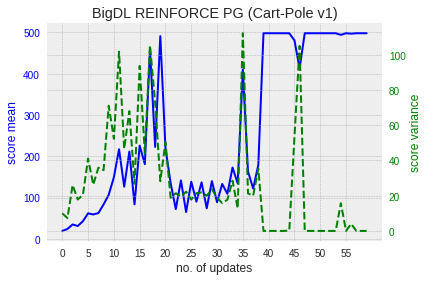

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
plt.style.use('bmh')
arr = np.asarray(mean_std)
print arr.shape
fig, ax1 = plt.subplots()
ind=np.arange(0,arr.shape[0],1)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,arr[:,0], 'b-')
ax1.set_xlabel('no. of updates')
ax1.set_xticks(ind[::5])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,arr[:,1], 'g--')
ax2.set_ylabel('score variance', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('BigDL REINFORCE PG (Cart-Pole v1)');